In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
import numpy as np
from pytorch_lightning import LightningModule, Trainer
from efficientnet_pytorch import EfficientNet

In [2]:
# -------- 1. Dataset --------
class LithoZernikeDataset(Dataset):
    def __init__(self, root_dir, num_zernike=20, image_size=2048, augment=True):
        self.pairs = []  # (input_img_path, target_img_path, coeffs)
        self.num_zernike = num_zernike
        self.image_size = image_size
        self.augment = augment

        for ab_folder in sorted(os.listdir(root_dir)):
            folder_path = os.path.join(root_dir, ab_folder)
            if not os.path.isdir(folder_path):
                continue
            # Parse Zernike index and coefficient from folder name, e.g., "4Z3"
            if 'Z' in ab_folder:
                parts = ab_folder.replace('-', ' -').split('Z')
                coef = float(parts[0])
                idx = int(parts[1])
                coeffs = np.zeros(num_zernike, dtype=np.float32)
                if idx < num_zernike:
                    coeffs[idx] = coef
            else:
                continue

            for imgname in os.listdir(folder_path):
                if not imgname.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    continue
                input_img_path = os.path.join(folder_path, imgname)
                # Предполагаем, что у тебя есть target-изображение с тем же именем в папке "target"
                target_img_path = os.path.join(root_dir, 'target', imgname)
                self.pairs.append((input_img_path, target_img_path, coeffs.copy()))

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        input_img_path, target_img_path, coeffs = self.pairs[idx]
        input_img = Image.open(input_img_path).convert('L')
        target_img = Image.open(target_img_path).convert('L')

        # Augmentation (rotation + flip)
        if self.augment:
            angle = np.random.choice([0, 90, 180, 270])
            flip_h = np.random.rand() > 0.5
            flip_v = np.random.rand() > 0.5
            input_img = TF.rotate(input_img, angle)
            target_img = TF.rotate(target_img, angle)
            if flip_h:
                input_img = TF.hflip(input_img)
                target_img = TF.hflip(target_img)
            if flip_v:
                input_img = TF.vflip(input_img)
                target_img = TF.vflip(target_img)

        input_img = self.transform(input_img)  # 1 x H x W
        target_img = self.transform(target_img)
        # Stack to shape [2, H, W]
        imgs = torch.cat([input_img, target_img], dim=0)
        return imgs, torch.from_numpy(coeffs)

In [3]:
# -------- 2. Model --------
class LithoZernikeRegressor(LightningModule):
    def __init__(self, num_zernike=20, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.backbone = EfficientNet.from_name('efficientnet-b0', in_channels=2)
        in_features = self.backbone._fc.in_features
        self.backbone._fc = torch.nn.Linear(in_features, num_zernike)

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        imgs, coeffs = batch
        preds = self(imgs)
        loss = torch.nn.functional.mse_loss(preds, coeffs)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, coeffs = batch
        preds = self(imgs)
        loss = torch.nn.functional.mse_loss(preds, coeffs)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [4]:
# -------- 3. DataLoader --------
def make_dataloaders(root, batch_size=16, num_zernike=20):
    train_dataset = LithoZernikeDataset(root, num_zernike=num_zernike, augment=False)
    val_dataset = LithoZernikeDataset(root, num_zernike=num_zernike, augment=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    return train_loader, val_loader

In [5]:
train_loader, val_loader = make_dataloaders('dataset', batch_size=4, num_zernike=6)
a = next(iter(train_loader))
len(a)

2

Aberrations: Z=[0. 3. 0. 0. 0. 0.]


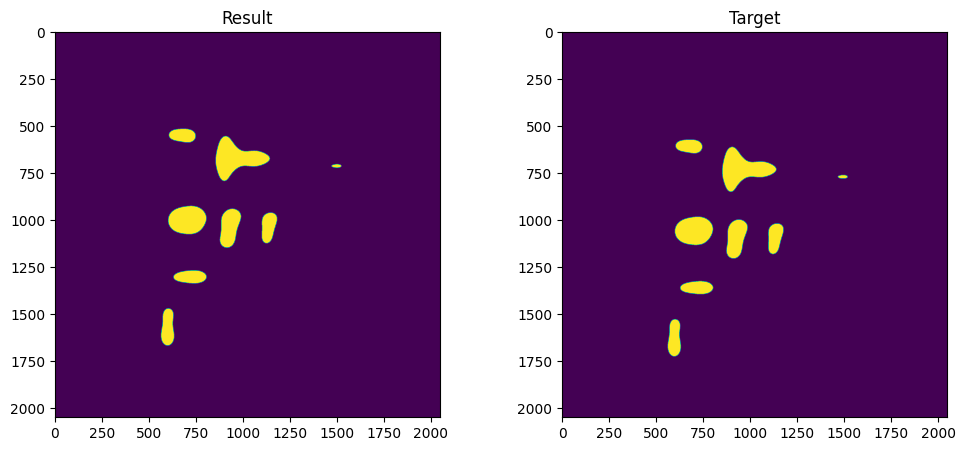

In [6]:
from matplotlib import pyplot as plt

i = 3
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,2,1)
plt.imshow(a[0][i][0])
ax.set_title("Result")
ax = plt.subplot(1,2,2)
plt.imshow(a[0][i][1])
ax.set_title("Target")
print(f"Aberrations: Z={a[1][i].numpy()}")
plt.show()

In [ ]:
# -------- 4. Training --------
train_loader, val_loader = make_dataloaders('dataset', batch_size=4, num_zernike=6)
model = LithoZernikeRegressor(num_zernike=6)
trainer = Trainer(max_epochs=20, accelerator='auto', accumulate_grad_batches = 32,
    gradient_clip_val=1., precision="16-mixed")
trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/root/anaconda3/envs/SK/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/tor

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]